# Simulating Relax displacements with a basal dislocation

## Set up triangular dislocation sources

`tri_horizon` generates a subhorizontal mesh representing the elastic-viscous interface, or the crust-mantle interface (CMI). `make_meshes` creates two meshes: one for the source fault and one for the CMI (by calling `tri_horizon`).

In [1]:
def tri_horizon(x, y, z, el_size):
    # Makes a simple ~horizon of triangular dislocation elements using Gmsh
    # x, y are 2-element arrays defining horizontal bounds
    # z is a scalar giving depth 
    # el_size gives nominal element size 

    import gmsh
    import meshio
    
    # Mesh construction using Gmsh
    gmsh.initialize()
    # Define points
    gmsh.model.geo.addPoint(x[0], y[0], z-0.01, el_size, 1)
    gmsh.model.geo.addPoint(x[1], y[0], z+0.01, el_size, 2)
    gmsh.model.geo.addPoint(x[1], y[1], z+0.01, el_size, 3)
    gmsh.model.geo.addPoint(x[0], y[1], z-0.01, el_size, 4)
    # Boundary lines
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)
    # Perimeter
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    # Surface
    gmsh.model.geo.addPlaneSurface([1], 1)
    gmsh.model.geo.synchronize()
    # Generate and write. Writing a file allows use of meshio, consistent with celeri codes
    gmsh.model.mesh.generate(2)
    gmsh.write("file.msh")
    gmsh.finalize()

    # Read and parse mesh
    mesh = meshio.read("file.msh")
    fault_pts = mesh.points
    fault_tri = meshio.CellBlock("triangle", mesh.get_cells_type("triangle")).data
    return fault_pts, fault_tri

import numpy as np
import addict

# Template mesh. Depth will be adjusted for each model 
meshes = addict.Dict()
meshes[0].coords, meshes[0].verts = tri_horizon(x=[-120, 120], y=[-120, 120], z=0, el_size=12)
horiz_tri_pts = meshes[0].coords[meshes[0].verts]
ntri = np.size(horiz_tri_pts, axis=0)
n_source_tri = 0

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000160292s, CPU 0.000237s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00779542s, CPU 0.007715s)
Info    : 513 nodes 1028 elements
Info    : Writing 'file.msh'...
Info    : Done writing 'file.msh'



# Inversion of `Relax` displacements

We invert displacements calculated through viscoelatic simulations in `Relax`, estimating slip on the horizon at each time step. Each simulation tests a different combination of source fault dip, depth of the CMI, and viscosity of viscous medium. Slip estimations are subject to Laplacian smoothing.

## Assemble elastic dislocation partial derivatives and smoothing arrays

In [2]:
def matrix_assembly(meshes, disp_mat, smoothing_weight):
    
    import celeri 
    import addict 
    
    # Get triangular smoothing matrix
    operators = addict.Dict()
    celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

    nobs = 3*np.size(disp_mat, axis=0)
    ntri = np.size(disp_mat, axis=2)
    
    # Assemble matrices
    assembled_mat = np.zeros((nobs+3*ntri, 3*ntri))
    # Insert elastic partials
    assembled_mat[0:nobs, :] = disp_mat.reshape((-1, 3*ntri))
    # Insert smoothing matrices
    tri_row_start = nobs
    tri_row_end = tri_row_start + 3*ntri
    assembled_mat[tri_row_start:, :] = operators.smoothing_matrix[0].toarray()

    # Assemble weighting vector
    weights = np.ones((np.shape(assembled_mat)[0], 1))
    weights[tri_row_start:] = smoothing_weight

    return assembled_mat, weights

## Sequential reading and inversion of displacement grids

In [3]:
import glob
import cutde.halfspace as cutde_halfspace
import numpy as np 
import pygmt 
import xarray as xa
###
### GEOMETRY ELEMENTS
###

# Get observation locations from a Relax grid file
directory = "./parameter_ranges/output_dip10_z1.0_eta0.1"
pathname = directory + "/000-east.grd"
grid = pygmt.load_dataarray(pathname)
gsubset = 10 # Subset of grid points: increment every gsubset points along grid
xg = np.array(grid.x)
yg = np.array(grid.y)
Xg, Yg = np.meshgrid(xg, yg)
obsg_full = np.array([Xg, Yg, 0*Yg]).reshape((3, -1)).T.copy()
grid_dim = np.shape(grid)[0]
# Identify row and column indices of grid subset
ri, ci = np.meshgrid(np.arange(0, grid_dim, gsubset), np.arange(0, grid_dim, gsubset))
# Convert to linear index
li = ri*grid_dim + ci
li = li.T.reshape((-1,))
# Create the grid subset
obsg = obsg_full[li, :]
# Index indicating start of TDE data (smoothing pseudodata)
tri_row_start = np.size(obsg)

###
### PARAMETER RANGES
###

# List of dips to test
dips = np.arange(10, 90, 10)
# dips = np.array([20])

# List of depth multipliers: 
# Fault depth will be calculated, then multiplied by depth multiplier to define thickness of elastic layer
depth_mults = np.arange(1, 4, 1).astype(float)
# depth_mults = np.array([2]).astype(float)

# List of viscosities to test
# Framed as gammadot = 1/Maxwell time
maxwell_times = np.array([10, 5, 1])
# maxwell_times = np.array([1])
viscosities = 1./maxwell_times

# List of smoothing weights to test
smooths = [1e-6, 1e-3, 1e0]
# smooths = np.array([1e-3])

###
### ALLOCATE SPACE FOR ALL RESULTS
###

# Selected times, expressed in postseismic years
sel_times = np.array([1, 10, 20])
n_times = len(sel_times)

# Outer conditional: check to see if calculations have already been run and saved


# Allocate space for estimated slip and predicted displacements
# Hard coded for 500 time steps; can trim unused columns later
n_trials = len(dips)*len(depth_mults)*len(smooths)*len(viscosities)
est_slip = np.zeros((3*ntri, n_times, n_trials))
pred_disp = np.zeros((obsg_full.size, n_times, n_trials))
time_vectors = np.zeros((n_times, n_trials))

# Allocate space for data vector
data_vector = np.zeros(tri_row_start+3*ntri)

# Cumulative counting index
totalidx = -1



### Carry out slip estimation and write H5 files with estimated slip and predicted displacements

Only need to run this once, as H5 files can be read in using the next cell if already saved

In [ ]:
# Loop through all dips
# This needs to be the outermost loop because depth of horizon depends on source fault dip
for dipi in range(len(dips)):   
    # Loop through all depths
    for depthi in range(len(depth_mults)):
        # Calculate elastic partial derivatives for this particular horizon configuration
        
        # Define horizon at set depth
        fault_depth = 17*np.sin(np.radians(dips[dipi])) # Fault width is 17 
        thick = depth_mults[depthi]*fault_depth # Thickness of elastic layer 
        
        # Adjust depth of triangle coordinates
        these_horiz_tri_pts = np.copy(horiz_tri_pts)
        these_horiz_tri_pts[:, :, 2] = horiz_tri_pts[:, :, 2] - thick

        # Calculate partial derivatives
        disp_mat = cutde_halfspace.disp_matrix(obs_pts=obsg_full, tris=these_horiz_tri_pts, nu=0.25)

        # Loop through potential smoothing values
        for smoothi in range(len(smooths)):
            # Assemble with smoothing
            assembled_mat, weights = matrix_assembly(meshes, disp_mat[li, :, :, :], smoothing_weight=smooths[smoothi])

            # Calculate model covariance
            cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat)

            # Loop through viscosities
            for visci in range(len(viscosities)):
                totalidx += 1
                # Assemble Relax simulation filename
                sh_name = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dipi], depth_mults[depthi], viscosities[visci])
                directory = f"./parameter_ranges/output_{sh_name[:-3]}".format()
                # Read time vector
                time_vector = np.loadtxt(directory + "/time.txt", unpack=False)
                # time_vectors[0:len(time_vector), totalidx] = time_vector
                
                # Determine index of selected times
                sel_times_idx = np.nonzero(np.isin(time_vector, sel_times))[0]
                
                # Read sequence of displacement grd files
                e_disp_file_list = sorted(glob.glob(directory + "/*-relax-east.grd"))
                n_disp_file_list = sorted(glob.glob(directory + "/*-relax-north.grd"))
                u_disp_file_list = sorted(glob.glob(directory + "/*-relax-up.grd"))

                # Read each file and estimate slip
                for i in range(len(sel_times_idx)):
                    # Read displacement components
                    e_disp = pygmt.load_dataarray(e_disp_file_list[sel_times_idx[i]])
                    n_disp = pygmt.load_dataarray(n_disp_file_list[sel_times_idx[i]])
                    u_disp = pygmt.load_dataarray(u_disp_file_list[sel_times_idx[i]])
                    # Take the same spatial subset as when setting up partials
                    disp_array = np.array([e_disp[0::gsubset, 0::gsubset], n_disp[0::gsubset, 0::gsubset], u_disp[0::gsubset, 0::gsubset]]).reshape((3, -1)).T.copy()
                    data_vector[0:tri_row_start] = disp_array.flatten()
                    # Estimate slip using pre-calculated covariance
                    est_slip[:, i, totalidx] = cov @ assembled_mat.T * weights.T @ data_vector 
                    # Predict displacement at the full grid resolution
                    pred_disp[:, i, totalidx] = disp_mat.reshape((-1, 3*ntri)).dot(est_slip[:, i, totalidx])

import h5py
slipf = h5py.File("./parameter_ranges/est_slip.h5", "w")
dset = slipf.create_dataset("est_slip", data=est_slip)
slipf.close()

dispf = h5py.File("./parameter_ranges/pred_disp.h5", "w")
dset = dispf.create_dataset("pred_disp", data=pred_disp)
dispf.close()

### Read H5 files back in

In [4]:
import h5py
import numpy as np 
slipf = h5py.File("./parameter_ranges/est_slip.h5", "r")
est_slip = np.array(slipf.get("est_slip"))
slipf.close()

dispf = h5py.File("./parameter_ranges/pred_disp.h5", "r")
pred_disp = np.array(dispf.get("pred_disp"))
dispf.close()

/var/folders/fg/yxk4m2b97gd8fx9whgk386y5szvp8k/T/ipykernel_25765/866493363.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  est_slip = np.array(slipf.get("est_slip"))
/var/folders/fg/yxk4m2b97gd8fx9whgk386y5szvp8k/T/ipykernel_25765/866493363.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pred_disp = np.array(dispf.get("pred_disp"))


## Plot results

### Figure 2: Comparative displacement grids 

This code block generates a paired figure that compares two dislocation simulations. The idea is to see how an individual parameter may affect the pattern of modeled displacements and the corresponding estimation of basal horizon slip. 

In the first lines of the code block, pairs of indices for dip, depth, smoothing weight, and viscosity can be specified. To see how a single parameter impacts the displacement field and estimated basal horizon slip, set the first and second value of all but one index pair to be the same. That way, the impact of a single parameter change can be assesed. In the example given as Figure 1 of the paper, source fault dips of 20º and 60º are compared, using a depth factor that is $2\times$ the fault locking depth, a Maxwell time of 5 years, and a smoothing weight of $\beta=10^{-3}$. Three figures are produced, representing cumulative postseismic displacement at 1, 10, and 20 years after the earthquake; the 10 year map is shown in the paper. 

[-0.05342129  0.12940449]
[-0.0477276   0.02291021]


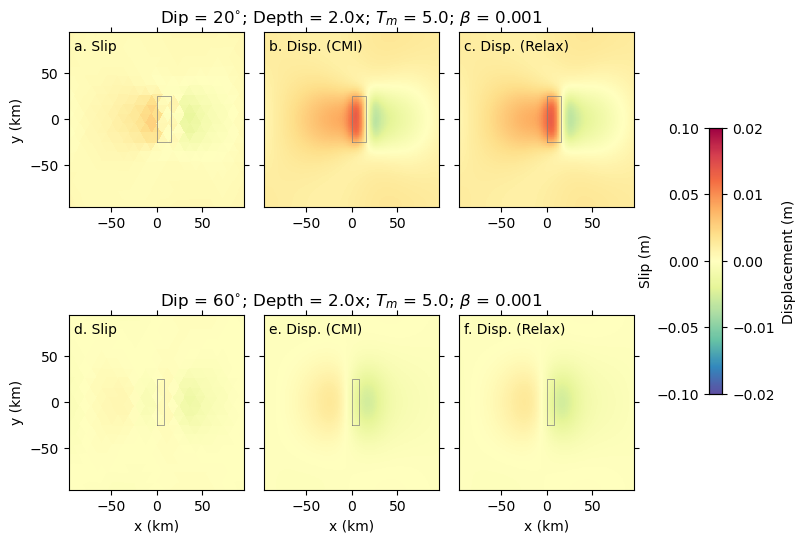

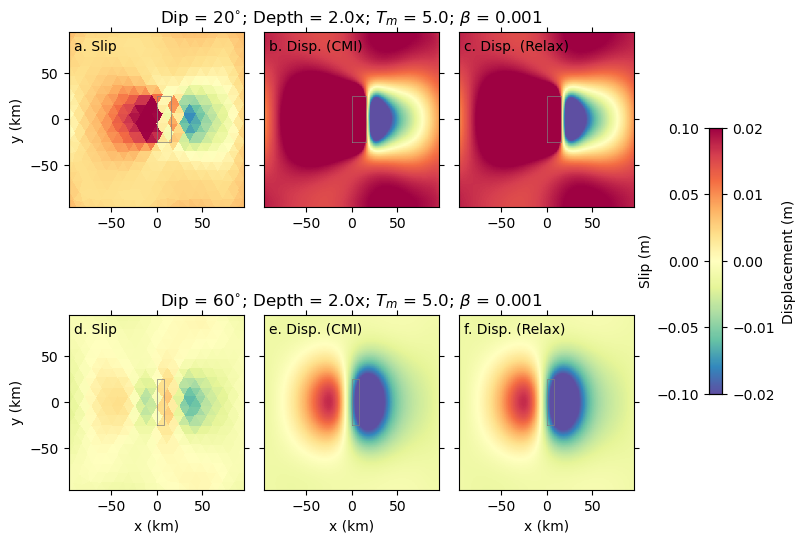

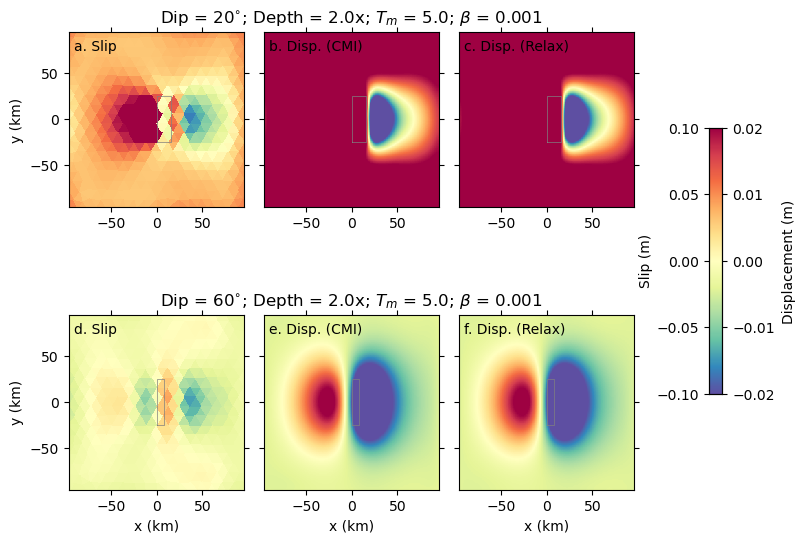

In [7]:
# Import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
plt.rcParams["savefig.format"] = 'pdf'

# Reminders of parameter ranges

# dips = np.arange(10, 90, 10)
# depth_mults = np.arange(1, 4, 1).astype(float)
# maxwell_times = np.array([10, 5, 1])
# viscosities = 1./maxwell_times
# smooths = [1e-6, 1e-3, 1e0]

# Specify parameters to be plotted 
dip_idx = np.array([1, 5])
dep_idx = np.array([1, 1])
smo_idx = np.array([1, 1])
vis_idx = np.array([1, 1])

# Source fault outline coordinates
sfo_x = np.array([np.zeros_like(dips), 17*np.ones_like(dips)*np.cos(np.deg2rad(dips)), 17*np.ones_like(dips)*np.cos(np.deg2rad(dips)), np.zeros_like(dips), np.zeros_like(dips)])
sfo_y = 25*np.array([-np.ones_like(dips), -np.ones_like(dips), np.ones_like(dips), np.ones_like(dips), -np.ones_like(dips)])
sfo_z = np.array([np.zeros_like(dips), 17*np.ones_like(dips)*np.sin(np.deg2rad(dips)), 17*np.ones_like(dips)*np.sin(np.deg2rad(dips)), np.zeros_like(dips), np.zeros_like(dips)])

sel_times = np.array([1, 10, 20])
# sel_times = np.array([10])

# File and directory names
sh_name0 = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dip_idx[0]], depth_mults[dep_idx[0]], viscosities[vis_idx[0]])
directory0 = f"./parameter_ranges/output_{sh_name0[:-3]}".format()
time_vector0 = np.loadtxt(directory0 + "/time.txt", unpack=False)
sel_times_idx0 = np.nonzero(np.isin(time_vector0, sel_times))[0]

sh_name1 = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dip_idx[1]], depth_mults[dep_idx[1]], viscosities[vis_idx[1]])
directory1 = f"./parameter_ranges/output_{sh_name1[:-3]}".format()
time_vector1 = np.loadtxt(directory1 + "/time.txt", unpack=False)
sel_times_idx1 = np.nonzero(np.isin(time_vector1, sel_times))[0]

# List of east displacement grd files 
e_disp_file_list0 = sorted(glob.glob(directory0 + "/*-relax-east.grd"))
e_disp_file_list1 = sorted(glob.glob(directory1 + "/*-relax-east.grd"))

# Model numbers for inversion results
mod_num0 = (len(depth_mults) * len(smooths) * len(viscosities))*dip_idx[0] + (len(smooths) * len(viscosities))*dep_idx[0] + (len(viscosities))*smo_idx[0] + vis_idx[0]
mod_num1 = (len(depth_mults) * len(smooths) * len(viscosities))*dip_idx[1] + (len(smooths) * len(viscosities))*dep_idx[1] + (len(viscosities))*smo_idx[1] + vis_idx[1]

# Set up axis and color limits
x_limits = np.array([np.min(xg), np.max(xg)])
y_limits = np.array([np.min(yg), np.max(yg)])
s_min = -0.1
s_max = np.abs(s_min)
d_min = -0.02
d_max = np.abs(d_min)

# For all time steps,
for i in range(len(sel_times)):
    # Read in Relax displacements
    e_disp0 = xa.load_dataarray(e_disp_file_list0[sel_times_idx0[i]])
    e_disp1 = xa.load_dataarray(e_disp_file_list1[sel_times_idx1[i]]) 

    # pyplot figure: 3 panels, TDE slips, TDE predicted surface displacements, and Relax displacements
    fig, ax = plt.subplots(2, 3, figsize=(8, 6))
    
    cmap_name="Spectral_r"
    so = ax[0, 0].tripcolor(meshes[0].coords[:, 0], meshes[0].coords[:, 1], meshes[0].verts, facecolors=est_slip[1::3, i, mod_num0], vmin=s_min, vmax=s_max, cmap=cmap_name)
    ax[0, 0].plot(sfo_x[:, dip_idx[0]], sfo_y[:, dip_idx[0]], color='gray', linewidth=0.5)
    do = ax[0, 1].pcolormesh(xg, yg, pred_disp[0::3, i, mod_num0].reshape(np.shape(Xg)), vmin=d_min, vmax=d_max, cmap=cmap_name)
    ax[0, 1].plot(sfo_x[:, dip_idx[0]], sfo_y[:, dip_idx[0]], color='gray', linewidth=0.5)
    ax[0, 2].pcolormesh(xg, yg, e_disp0.values, vmin=d_min, vmax=d_max, cmap=cmap_name)
    ax[0, 2].plot(sfo_x[:, dip_idx[0]], sfo_y[:, dip_idx[0]], color='gray', linewidth=0.5)
    ax[1, 0].tripcolor(meshes[0].coords[:, 0], meshes[0].coords[:, 1], meshes[0].verts, facecolors=est_slip[1::3, i, mod_num1], vmin=s_min, vmax=s_max, cmap=cmap_name)
    ax[1, 0].plot(sfo_x[:, dip_idx[1]], sfo_y[:, dip_idx[1]], color='gray', linewidth=0.5)
    ax[1, 1].pcolormesh(xg, yg, pred_disp[0::3, i, mod_num1].reshape(np.shape(Xg)), vmin=d_min, vmax=d_max, cmap=cmap_name)
    ax[1, 1].plot(sfo_x[:, dip_idx[1]], sfo_y[:, dip_idx[1]], color='gray', linewidth=0.5)
    ax[1, 2].pcolormesh(xg, yg, e_disp1.values, vmin=d_min, vmax=d_max, cmap=cmap_name)
    ax[1, 2].plot(sfo_x[:, dip_idx[1]], sfo_y[:, dip_idx[1]], color='gray', linewidth=0.5)
    ax[0, 1].set_title(str("Dip = " + str(dips[dip_idx[0]]) + "$^{\circ}$; Depth = " + str(depth_mults[dep_idx[0]]) + "x; $T_m$ = " + str(1/viscosities[vis_idx[0]]) + "; $\\beta$ = " + str(smooths[smo_idx[0]])))
    ax[1, 1].set_title(str("Dip = " + str(dips[dip_idx[1]]) + "$^{\circ}$; Depth = " + str(depth_mults[dep_idx[1]]) + "x; $T_m$ = " + str(1/viscosities[vis_idx[1]]) + "; $\\beta$ = " + str(smooths[smo_idx[1]])))

    plt.setp(ax, xlim=x_limits, ylim=y_limits, aspect="equal")
    ax[0, 0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
    ax[0, 1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
    ax[0, 2].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
    ax[1, 0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
    ax[1, 1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
    ax[1, 2].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)

    ax[0, 0].set_ylabel("y (km)")
    # ax[0, 2].set_ylabel("y")
    # ax[0, 2].yaxis.set_label_position("right")
    ax[1, 0].set_ylabel("y (km)")
    ax[1, 0].set_xlabel("x (km)")
    ax[1, 1].set_xlabel("x (km)")
    # ax[1, 2].set_ylabel("y")
    # ax[1, 2].yaxis.set_label_position("right")
    ax[1, 2].set_xlabel("x (km)")

    ax[0, 0].text(-90, 75, "a. Slip")
    ax[0, 1].text(-90, 75, "b. Disp. (CMI)")
    ax[0, 2].text(-90, 75, "c. Disp. (Relax)")
    ax[1, 0].text(-90, 75, "d. Slip")
    ax[1, 1].text(-90, 75, "e. Disp. (CMI)")
    ax[1, 2].text(-90, 75, "f. Disp. (Relax)")

    plt.tight_layout()
    cbar = fig.colorbar(so, ax=ax.ravel().tolist(), shrink=0.5)
    cbar.ax.set_yticks(np.arange(s_min, s_max+0.05, 0.05))
    cbar.ax.set_ylabel(ylabel="Slip (m)", labelpad=-60)
    pos = cbar.ax.get_position()
    cbar2 = cbar.ax.twinx()
    cbar2.set_ylim([d_min, d_max])
    cbar2.set_yticks(np.arange(d_min, d_max+0.01, 0.01))
    cbar2.set_ylabel(ylabel="Displacement (m)", labelpad=5)
    # resize the colorbar (otherwise it overlays the plot)
    pos.x0 +=0.05
    cbar.ax.set_position(pos)
    cbar2.set_position(pos)

    if i == 1:
        plt.savefig("20vs60.png")
        plt.savefig("20vs60.pdf")
    # fig.colorbar(co, ax=ax.ravel().tolist(), label="Slip (m)", shrink=0.6)


# Report extreme displacements for these models 
print(np.array((np.min(e_disp0), np.max(e_disp0))))
print(np.array((np.min(e_disp1), np.max(e_disp1))))


### Figure 3: Estimated CMI displacement and Relax interface displacement

Rather than showing displacement at the surface, this figure shows Relax-predicted displacements at the elastic-viscous interface. For the example here, that depth is 11.6 km, corresponding to $2\times$ the depth of the 20º-dipping fault. These displacements at depth are plotted alongside the estimated slip on the CMI elements to illustrate the correspondence between displacements at the elastic-viscous interface from viscous stress dissipation and displacements (slip) estimated at the base of the elastic layer. Again, three figures are produced, showing cumulative deformation at 1, 10, and 20 years after the earthquake; the 10 year map is shown in the paper. 

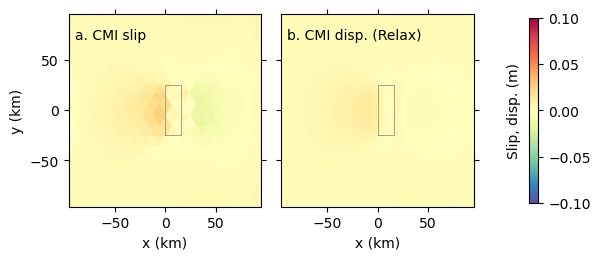

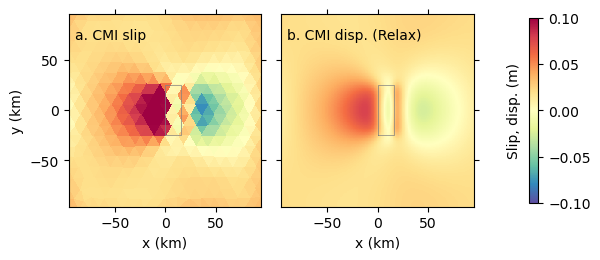

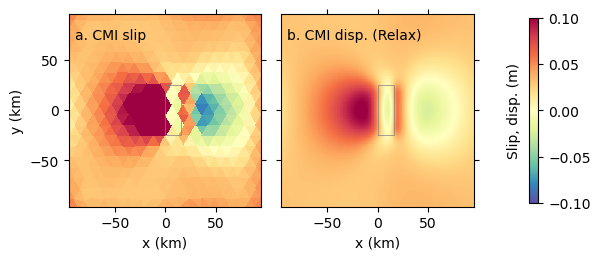

In [9]:
# Hard-coded for the reference model case

sel_times = np.array([1, 10, 20])

# Read east component of Relax displacements at selected times
# File and directory names
sh_name0 = 'dip20_z2.0_eta0.2_11km.sh'
directory0 = f"./parameter_ranges/output_{sh_name0[:-3]}".format()
time_vector0 = np.loadtxt(directory0 + "/time.txt", unpack=False)
sel_times_idx0 = np.nonzero(np.isin(time_vector0, sel_times))[0]

# List of east displacement grd files 
e_disp_file_list0 = sorted(glob.glob(directory0 + "/*-relax-east.grd"))

# Model number for inversion results
mod_num0 = (len(depth_mults) * len(smooths) * len(viscosities))*1 + (len(smooths) * len(viscosities))*1 + (len(viscosities))*1 + 1

# For all time steps,
for i in range(len(sel_times)):
    # Read in Relax displacements
    e_disp0 = xa.load_dataarray(e_disp_file_list0[sel_times_idx0[i]])
    
    # pyplot figure: 2 panels, TDE slips and Relax displacements
    fig, ax = plt.subplots(1, 2, figsize=(6, 4))
    
    cmap_name="Spectral_r"
    so = ax[0].tripcolor(meshes[0].coords[:, 0], meshes[0].coords[:, 1], meshes[0].verts, facecolors=est_slip[1::3, i, mod_num0], vmin=s_min, vmax=s_max, cmap=cmap_name)
    ax[0].plot(sfo_x[:, dip_idx[0]], sfo_y[:, dip_idx[0]], color='gray', linewidth=0.5)
    do = ax[1].pcolormesh(xg, yg, e_disp0.values, vmin=s_min, vmax=s_max, cmap=cmap_name)
    ax[1].plot(sfo_x[:, dip_idx[0]], sfo_y[:, dip_idx[0]], color='gray', linewidth=0.5)
    
    plt.setp(ax, xlim=x_limits, ylim=y_limits, aspect="equal")
    ax[0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
    ax[1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)

    ax[0].text(-90, 70, "a. CMI slip")
    ax[1].text(-90, 70, "b. CMI disp. (Relax)")

    ax[0].set_ylabel("y (km)")
    ax[0].set_xlabel("x (km)")
    ax[1].set_xlabel("x (km)")
    
    plt.tight_layout()
    cbar = fig.colorbar(so, ax=ax.ravel().tolist(), shrink=0.5)
    cbar.ax.set_yticks(np.arange(s_min, s_max+0.05, 0.05))
    cbar.ax.set_ylabel(ylabel="Slip, disp. (m)", labelpad=-60)
    pos = cbar.ax.get_position()
    # resize the colorbar (otherwise it overlays the plot)
    pos.x0 +=0.05
    cbar.ax.set_position(pos)

    if i == 1:
        plt.savefig("slip_disp_at_cmi.png")
        plt.savefig("slip_disp_at_cmi.pdf")
    

### Figure 1: 3D perspective diagram to show model setup

Here we show the reference model (20º dip, CMI depth 2x the extent of the fault, Maxwell time of 5 years) as a 3D plot to represent the geometry of the CMI TDE approach. 

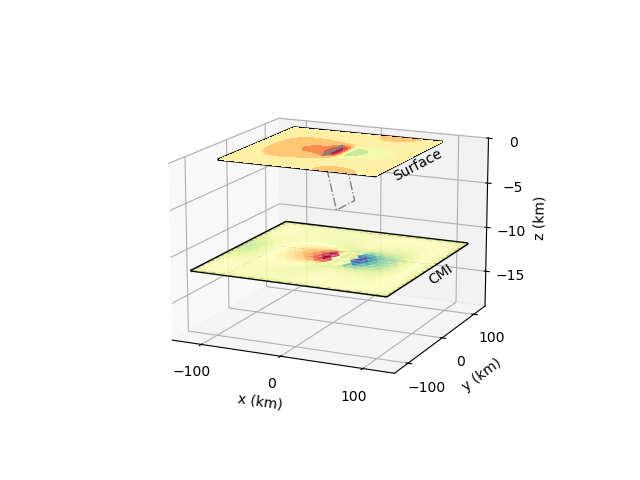

In [12]:
import matplotlib.tri as mtri
import mpl_toolkits.mplot3d.art3d as ar3
%matplotlib widget

# Hard-coded for the reference model case

sel_times = np.array([10])

# Read east component of Relax displacements at selected times
# File and directory names
sh_name0 = 'dip20_z2.0_eta0.2.sh'
directory0 = f"./parameter_ranges/output_{sh_name0[:-3]}".format()
time_vector0 = np.loadtxt(directory0 + "/time.txt", unpack=False)
sel_times_idx0 = np.nonzero(np.isin(time_vector0, sel_times))[0]

# List of east displacement grd files 
e_disp_file_list0 = sorted(glob.glob(directory0 + "/*-relax-east.grd"))

# Model number for inversion results
mod_num0 = (len(depth_mults) * len(smooths) * len(viscosities))*1 + (len(smooths) * len(viscosities))*1 + (len(viscosities))*1 + 1

i = 0

# Read in Relax displacements
e_disp0 = xa.load_dataarray(e_disp_file_list0[sel_times_idx0[i]])

# pyplot figure: 2 panels, TDE slips and Relax displacements
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set(xlabel="x (km)", ylabel="y (km)", zlabel="z (km)")

cmap_name="Spectral_r"
# Arrays of each triangle's coordinates
fault_depth = 17*np.sin(np.radians(20)) # Fault width is 17 
thick = 2*fault_depth # Thickness of elastic layer 
        
x=meshes[0].coords[:, 0]
y=meshes[0].coords[:, 1]
z=meshes[0].coords[:, 2] - thick
tri_points=meshes[0].verts
verts = ( [ np.array( [ [ x[ t[0] ] , y[ t[0] ] , z[ t[0] ] ]
, [ x[ t[1] ] , y[ t[1] ] , z[ t[1] ] ]
, [ x[ t[2] ] , y[ t[2] ] , z[ t[2] ] ] ] )
for t in tri_points
]
)

cmspecr = plt.get_cmap(cmap_name)
triCol = ar3.Poly3DCollection( verts, cmap=cmspecr)
triCol.set_array (est_slip[1::3, i, mod_num0])
tro = ax.add_collection(triCol)
perimmx = np.array((min(x), max(x), max(x), min(x), min(x)))
perimmy = np.array((min(y), min(y), max(y), max(y), min(y)))
ax.plot(perimmx, perimmy, np.zeros_like(perimmx)-thick, 'k', linewidth=2)
# ax.plot_trisurf(x=meshes[0].coords[:, 0], y=meshes[0].coords[:, 1], z=meshes[0].coords[:, 2], triangles=meshes[0].verts, cmap=cmap_name) 
# ax.tripcolor(meshes[0].coords[:, 0], meshes[0].coords[:, 1], meshes[0].verts, facecolors=est_slip[1::3, i, mod_num0], vmin=s_min, vmax=s_max, cmap=cmap_name)
ax.contourf(xg, yg, e_disp0.values, zdir='z', offset=0, vmin=s_min, vmax=s_max, cmap=cmap_name)
perimgx = np.array((min(xg), max(xg), max(xg), min(xg), min(xg)))
perimgy = np.array((min(yg), min(yg), max(yg), max(yg), min(yg)))
ax.plot(perimgx, perimgy, np.zeros_like(perimgx), 'k', linewidth=2)
ax.plot(sfo_x[:, dip_idx[0]], sfo_y[:, dip_idx[0]], -sfo_z[:, dip_idx[0]]+0.01, color='gray', linewidth=1, linestyle='-.', zorder=0)
ax.plot(sfo_x[[0, 3], dip_idx[0]], sfo_y[[0, 3], dip_idx[0]],color='gray', linewidth=2, zorder=20)

ax.set_zlim3d(-19, 0.02)
# plt.setp(ax, xlim=x_limits, ylim=y_limits, aspect="equal")
# ax[0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
# ax[1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=True, top=True, left=True, right=True)

# ax[0].text(-90, 70, "a. Slip")
# ax[1].text(-90, 70, "b. Relax disp.")
ax.set_zticks(np.arange(-15, 5, 5))
ax.set_yticks(np.arange(-100, 200, 100))
ax.set_xticks(np.arange(-100, 200, 100))
ax.text(170, -130, -thick+2, 'CMI', zdir='y')
ax.text(120, -110, 0, 'Surface', zdir='y')
ax.grid(visible=True)
ax.view_init(elev=15, azim=295)
plt.savefig("3d_view.png")
plt.savefig("3d_view.pdf")
plt.show()
    

### Figure 4: CMI slip profiles

This figure shows the pattern of estimated dip-slip on the crust-mantle interface from a suite of models. Each panel varies one parameter while using the other parameters of the reference model (dip = 20º, CMI depth 2x the fault extent, Maxwell time of 5 years, and smoothing weight of 0.001), the profile of which is repeated in red in each panel. 

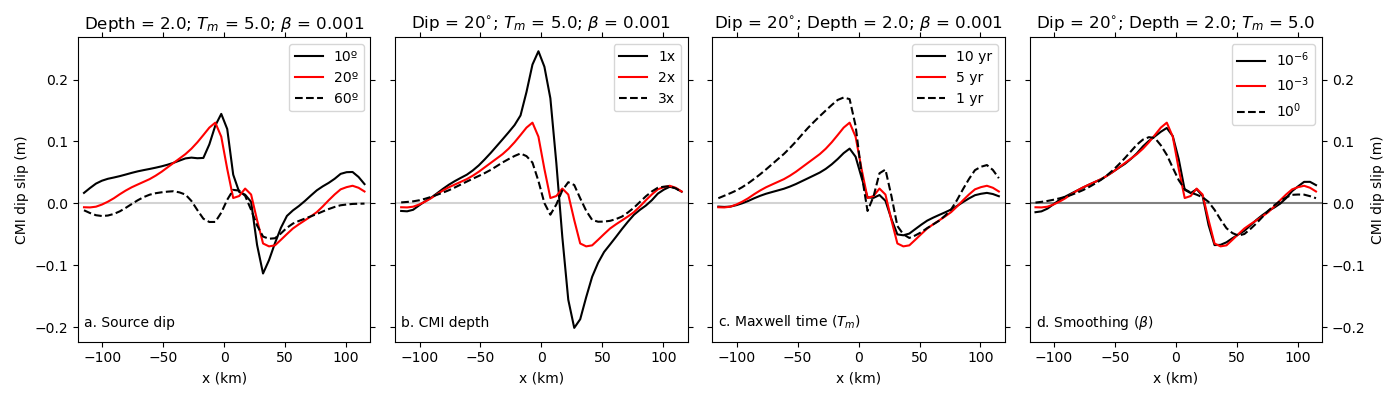

[0.14456093 0.13041326 0.02170326]
[0.24582057 0.13041326 0.08059374]
[0.08843246 0.13041326 0.17106741]
[0.12181286 0.13041326 0.10692656]
1.9344413117051615


In [13]:
from scipy.interpolate import LinearNDInterpolator
from scipy.signal import find_peaks, peak_widths

plt.close("all")
# Define profile across middle of mesh
horiz_centroids = np.mean(horiz_tri_pts, axis=1)
xprofile = np.linspace(-120, 120)
yprofile = 0*xprofile
fig, (dipax, depax, visax, smoax) = plt.subplots(1, 4, sharey=True, figsize=(14,4))

sel_times = 10

these_lines = ['k', 'r', 'k--']

###########
# Dip panel
###########
dip_idx = np.array([0, 1, 5])
dep_idx = np.array([1])
smo_idx = np.array([1])
vis_idx = np.array([1])

# Peak magnitudes for each of these models
peak_slip_dip = np.zeros(len(dip_idx))

for i in range(len(dip_idx)):
    # File and directory names
    sh_name0 = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dip_idx[i]], depth_mults[dep_idx[0]], viscosities[vis_idx[0]])
    directory0 = f"./parameter_ranges/output_{sh_name0[:-3]}".format()
    time_vector0 = np.loadtxt(directory0 + "/time.txt", unpack=False)
    sel_times_idx0 = np.nonzero(np.isin(time_vector0, sel_times))[0]
    # Model numbers for inversion results
    mod_num0 = (len(depth_mults) * len(smooths) * len(viscosities))*dip_idx[i] + (len(smooths) * len(viscosities))*dep_idx + (len(viscosities))*smo_idx + vis_idx

    # Interpolate dip slip
    interp = LinearNDInterpolator(list(zip(horiz_centroids[:, 0], horiz_centroids[:, 1])), est_slip[3*n_source_tri+1::3, 1, mod_num0])
    interp_slip = interp(xprofile, yprofile)
    dipax.plot(xprofile, interp_slip, these_lines[i], zorder=i+10)

    # Extract peak slip 
    peak_slip_dip[i] = np.nanmax(interp_slip)

dipax.set_xlim(-120, 120)
dipax.text(-115, -0.2, "a. Source dip")
dipax.legend(['10º', '20º', '60º'])
dipax.hlines(0, xmin=min(xprofile), xmax=max(xprofile), colors="lightgray", zorder=0)
dipax.set_xlabel('x (km)')
dipax.set_ylabel('CMI dip slip (m)')
dipax.set_title(str("Depth = " + str(depth_mults[dep_idx[0]]) + "; $T_m$ = " + str(1/viscosities[vis_idx[0]]) + "; $\\beta$ = " + str(smooths[smo_idx[0]])))


#############
# Depth panel
#############
dip_idx = np.array([1])
dep_idx = [0, 1, 2]
smo_idx = np.array([1])
vis_idx = np.array([1])

# Peak magnitudes for each of these models
peak_slip_dep = np.zeros(len(dep_idx))

for i in range(len(dep_idx)):
    # File and directory names
    sh_name0 = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dip_idx[0]], depth_mults[dep_idx[i]], viscosities[vis_idx[0]])
    directory0 = f"./parameter_ranges/output_{sh_name0[:-3]}".format()
    time_vector0 = np.loadtxt(directory0 + "/time.txt", unpack=False)
    sel_times_idx0 = np.nonzero(np.isin(time_vector0, sel_times))[0]
    # Model numbers for inversion results
    mod_num0 = (len(depth_mults) * len(smooths) * len(viscosities))*dip_idx + (len(smooths) * len(viscosities))*dep_idx[i] + (len(viscosities))*smo_idx + vis_idx

    # Interpolate dip slip
    interp = LinearNDInterpolator(list(zip(horiz_centroids[:, 0], horiz_centroids[:, 1])), est_slip[3*n_source_tri+1::3, 1, mod_num0])
    interp_slip = interp(xprofile, yprofile)
    depax.plot(xprofile, interp_slip, these_lines[i], zorder=i+10)
    
    # Extract peak slip 
    peak_slip_dep[i] = np.nanmax(interp_slip)

depax.set_xlim(-120, 120)
depax.text(-115, -0.2, "b. CMI depth")
depax.legend(['1x', '2x', '3x'])
depax.hlines(0, xmin=min(xprofile), xmax=max(xprofile), colors="lightgray", zorder=0)
depax.set_xlabel('x (km)')
depax.set_title(str("Dip = " + str(dips[dip_idx[0]]) + "$^{\circ}$; $T_m$ = " + str(1/viscosities[vis_idx[0]]) + "; $\\beta$ = " + str(smooths[smo_idx[0]])))


#################
# Viscosity panel
#################
dip_idx = np.array([1])
dep_idx = np.array([1])
smo_idx = np.array([1])
vis_idx = [0, 1, 2]

# Peak magnitudes for each of these models
peak_slip_vis = np.zeros(len(vis_idx))

for i in range(len(vis_idx)):
    # File and directory names
    sh_name0 = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dip_idx[0]], depth_mults[dep_idx[0]], viscosities[vis_idx[i]])
    directory0 = f"./parameter_ranges/output_{sh_name0[:-3]}".format()
    time_vector0 = np.loadtxt(directory0 + "/time.txt", unpack=False)
    sel_times_idx0 = np.nonzero(np.isin(time_vector0, sel_times))[0]
    # Model numbers for inversion results
    mod_num0 = (len(depth_mults) * len(smooths) * len(viscosities))*dip_idx + (len(smooths) * len(viscosities))*dep_idx + (len(viscosities))*smo_idx + vis_idx[i]

    # Interpolate dip slip
    interp = LinearNDInterpolator(list(zip(horiz_centroids[:, 0], horiz_centroids[:, 1])), est_slip[3*n_source_tri+1::3, 1, mod_num0])
    interp_slip = interp(xprofile, yprofile)
    visax.plot(xprofile, interp_slip, these_lines[i], zorder=i+10)

    # Extract peak slip 
    peak_slip_vis[i] = np.nanmax(interp_slip)

visax.set_xlim(-120, 120)
visax.text(-115, -0.2, "c. Maxwell time ($T_m$)")
visax.legend(['10 yr', '5 yr', '1 yr'])
visax.hlines(0, xmin=min(xprofile), xmax=max(xprofile), colors="lightgray", zorder=0)
visax.set_xlabel('x (km)')
visax.set_title(str("Dip = " + str(dips[dip_idx[0]]) + "$^{\circ}$; Depth = " + str(depth_mults[dep_idx[0]]) + "; $\\beta$ = " + str(smooths[smo_idx[0]])))

#################
# Smoothing panel
#################
dip_idx = np.array([1])
dep_idx = np.array([1])
smo_idx = np.array([0, 1, 2])
vis_idx = [1]

# Peak magnitudes for each of these models
peak_slip_smo = np.zeros(len(smo_idx))

# File and directory names
sh_name0 = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dip_idx[0]], depth_mults[dep_idx[0]], viscosities[vis_idx[0]])
directory0 = f"./parameter_ranges/output_{sh_name0[:-3]}".format()
time_vector0 = np.loadtxt(directory0 + "/time.txt", unpack=False)
sel_times_idx0 = np.nonzero(np.isin(time_vector0, sel_times))[0]

for i in range(len(smo_idx)):
    # Model numbers for inversion results
    mod_num0 = (len(depth_mults) * len(smooths) * len(viscosities))*dip_idx + (len(smooths) * len(viscosities))*dep_idx + (len(viscosities))*smo_idx[i] + vis_idx[0]

    # Interpolate dip slip
    interp = LinearNDInterpolator(list(zip(horiz_centroids[:, 0], horiz_centroids[:, 1])), est_slip[3*n_source_tri+1::3, 1, mod_num0])
    interp_slip = interp(xprofile, yprofile)
    smoax.plot(xprofile, interp_slip, these_lines[i], zorder=i+10)

    # Extract peak slip 
    max_slip = np.nanmax(interp_slip)
    peak_slip_smo[i] = max_slip
    

smoax.set_xlim(-120, 120)
smoax.text(-115, -0.2, "d. Smoothing ($\\beta$)")
smoax.legend(['$10^{-6}$', '$10^{-3}$', '$10^{0}$'])
smoax.hlines(0, xmin=min(xprofile), xmax=max(xprofile), colors="gray", zorder=0)
smoax.set_xlabel('x (km)')
smoax.yaxis.set_label_position("right")
smoax.set_ylabel('CMI dip slip (m)')
smoax.set_title(str("Dip = " + str(dips[dip_idx[0]]) + "$^{\circ}$; Depth = " + str(depth_mults[dep_idx[0]]) + "; $T_m$ = " + str(1/viscosities[vis_idx[0]])))

dipax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
depax.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
visax.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
smoax.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=True, top=True, left=True, right=True)

# common_y_lims = smoax.get_ylim()
# dipax.fill([-5, 5, 5, -5], [common_y_lims[0], common_y_lims[0], common_y_lims[1], common_y_lims[1]], color="lightgray", zorder=-1)
# depax.fill([-5, 5, 5, -5], [common_y_lims[0], common_y_lims[0], common_y_lims[1], common_y_lims[1]], color="lightgray", zorder=-1)
# visax.fill([-5, 5, 5, -5], [common_y_lims[0], common_y_lims[0], common_y_lims[1], common_y_lims[1]], color="lightgray", zorder=-1)
# smoax.fill([-5, 5, 5, -5], [common_y_lims[0], common_y_lims[0], common_y_lims[1], common_y_lims[1]], color="lightgray", zorder=-1)
# dipax.set_ylim(common_y_lims)
# depax.set_ylim(common_y_lims)
# visax.set_ylim(common_y_lims)
# smoax.set_ylim(common_y_lims)
fig.tight_layout()
plt.savefig("slipwavelength.png")
plt.savefig("slipwavelength.pdf")
plt.show()

# Print peak magnitudes
print(peak_slip_dip)
print(peak_slip_dep)
print(peak_slip_vis)
print(peak_slip_smo)

print(peak_slip_vis[2]/peak_slip_vis[0])



### Checking power law rheology

In [15]:
# Redefine selected times
sel_times = np.array([1, 10, 20])

# Define horizon at set depth
fault_depth = 17*np.sin(np.radians(20)) # Fault width is 17 
thick = 2*fault_depth # Thickness of elastic layer 
        
# Adjust depth of triangle coordinates
these_horiz_tri_pts = np.copy(horiz_tri_pts)
these_horiz_tri_pts[:, :, 2] = horiz_tri_pts[:, :, 2] - thick
# Calculate partial derivatives
disp_mat = cutde_halfspace.disp_matrix(obs_pts=obsg_full, tris=these_horiz_tri_pts, nu=0.25)
# Assemble with smoothing
assembled_mat, weights = matrix_assembly(meshes, disp_mat[li, :, :, :], smoothing_weight=smooths[1])

# Calculate model covariance
cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat)

# File and directory names
sh_name = 'dip20_z2.0_eta0.2_n3.sh'
directory = f"./parameter_ranges/output_{sh_name[:-3]}".format()
time_vector = np.loadtxt(directory + "/time.txt", unpack=False)
sel_times_idx = [np.argmin(np.abs(time_vector - sel_times[n])) for n in range(len(sel_times))]

# Read sequence of displacement grd files
e_disp_file_list = sorted(glob.glob(directory + "/*-relax-east.grd"))
n_disp_file_list = sorted(glob.glob(directory + "/*-relax-north.grd"))
u_disp_file_list = sorted(glob.glob(directory + "/*-relax-up.grd"))

# Allocate space for outputs
est_slip_n3 = np.zeros((3*ntri, n_times))
pred_disp_n3 = np.zeros((obsg_full.size, n_times))

# Read each file and estimate slip
for i in range(len(sel_times_idx)):
    # Read displacement components
    e_disp = pygmt.load_dataarray(e_disp_file_list[sel_times_idx[i]])
    n_disp = pygmt.load_dataarray(n_disp_file_list[sel_times_idx[i]])
    u_disp = pygmt.load_dataarray(u_disp_file_list[sel_times_idx[i]])
    # Take the same spatial subset as when setting up partials
    disp_array = np.array([e_disp[0::gsubset, 0::gsubset], n_disp[0::gsubset, 0::gsubset], u_disp[0::gsubset, 0::gsubset]]).reshape((3, -1)).T.copy()
    data_vector[0:tri_row_start] = disp_array.flatten()
    # Estimate slip using pre-calculated covariance
    est_slip_n3[:, i] = cov @ assembled_mat.T * weights.T @ data_vector 
    # Predict displacement at the full grid resolution
    pred_disp_n3[:, i] = disp_mat.reshape((-1, 3*ntri)).dot(est_slip_n3[:, i])


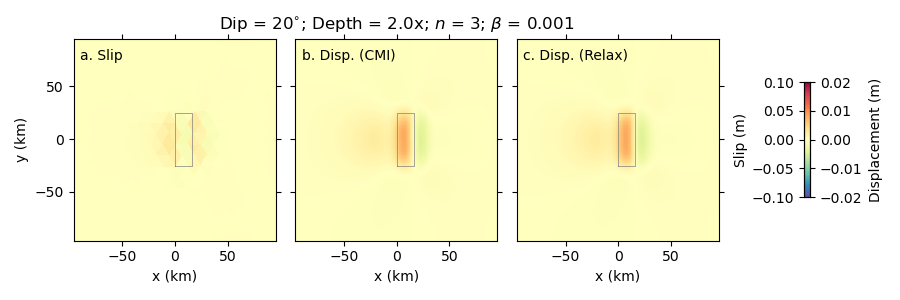

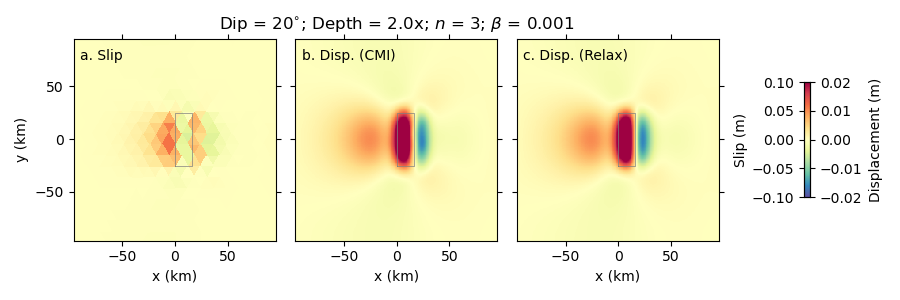

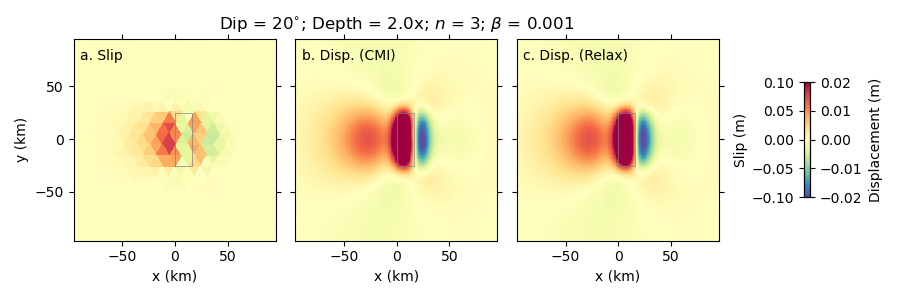

In [18]:
# Reminders of parameter ranges

# Specify parameters to be plotted 
dip_idx = np.array([1])
dep_idx = np.array([1])
smo_idx = np.array([1])
vis_idx = np.array([1])

# Source fault outline coordinates
sfo_x = np.array([np.zeros_like(dips), 17*np.ones_like(dips)*np.cos(np.deg2rad(dips)), 17*np.ones_like(dips)*np.cos(np.deg2rad(dips)), np.zeros_like(dips), np.zeros_like(dips)])
sfo_y = 25*np.array([-np.ones_like(dips), -np.ones_like(dips), np.ones_like(dips), np.ones_like(dips), -np.ones_like(dips)])
sfo_z = np.array([np.zeros_like(dips), 17*np.ones_like(dips)*np.sin(np.deg2rad(dips)), 17*np.ones_like(dips)*np.sin(np.deg2rad(dips)), np.zeros_like(dips), np.zeros_like(dips)])

sel_times = np.array([1, 10, 20])
# sel_times = np.array([10])

# Set up axis and color limits
x_limits = np.array([np.min(xg), np.max(xg)])
y_limits = np.array([np.min(yg), np.max(yg)])
s_min = -0.1
s_max = np.abs(s_min)
d_min = -0.02
d_max = np.abs(d_min)

# For all time steps,
for i in range(len(sel_times)):
    # Read in Relax displacements
    e_disp = xa.load_dataarray(e_disp_file_list[sel_times_idx[i]])
    
    # pyplot figure: 3 panels, TDE slips, TDE predicted surface displacements, and Relax displacements
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    
    cmap_name="Spectral_r"
    so = ax[0].tripcolor(meshes[0].coords[:, 0], meshes[0].coords[:, 1], meshes[0].verts, facecolors=est_slip_n3[1::3, i], vmin=s_min, vmax=s_max, cmap=cmap_name)
    ax[0].plot(sfo_x[:, dip_idx[0]], sfo_y[:, dip_idx[0]], color='gray', linewidth=0.5)
    do = ax[1].pcolormesh(xg, yg, pred_disp_n3[0::3, i].reshape(np.shape(Xg)), vmin=d_min, vmax=d_max, cmap=cmap_name)
    ax[1].plot(sfo_x[:, dip_idx[0]], sfo_y[:, dip_idx[0]], color='gray', linewidth=0.5)
    ax[2].pcolormesh(xg, yg, e_disp.values, vmin=d_min, vmax=d_max, cmap=cmap_name)
    ax[2].plot(sfo_x[:, dip_idx[0]], sfo_y[:, dip_idx[0]], color='gray', linewidth=0.5)
    ax[1].set_title(str("Dip = " + str(dips[dip_idx[0]]) + "$^{\circ}$; Depth = " + str(depth_mults[dep_idx[0]]) + "x; $n$ = 3; $\\beta$ = " + str(smooths[smo_idx[0]])))
    
    plt.setp(ax, xlim=x_limits, ylim=y_limits, aspect="equal")
    ax[0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
    ax[1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
    ax[2].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
    
    ax[0].set_ylabel("y (km)")
    # ax[0, 2].set_ylabel("y")
    # ax[0, 2].yaxis.set_label_position("right")
    ax[0].set_xlabel("x (km)")
    ax[1].set_xlabel("x (km)")
    ax[2].set_xlabel("x (km)")

    ax[0].text(-90, 75, "a. Slip")
    ax[1].text(-90, 75, "b. Disp. (CMI)")
    ax[2].text(-90, 75, "c. Disp. (Relax)")
    
    plt.tight_layout()
    cbar = fig.colorbar(so, ax=ax.ravel().tolist(), shrink=0.5)
    cbar.ax.set_yticks(np.arange(s_min, s_max+0.05, 0.05))
    cbar.ax.set_ylabel(ylabel="Slip (m)", labelpad=-55)
    pos = cbar.ax.get_position()
    cbar2 = cbar.ax.twinx()
    cbar2.set_ylim([d_min, d_max])
    cbar2.set_yticks(np.arange(d_min, d_max+0.01, 0.01))
    cbar2.set_ylabel(ylabel="Displacement (m)", labelpad=5)
    # resize the colorbar (otherwise it overlays the plot)
    pos.x0 +=0.05
    cbar.ax.set_position(pos)
    cbar2.set_position(pos)
    if i == 1:
        plt.savefig("power_law_n3.png")
        plt.savefig("power_law_n3.pdf")
    # fig.colorbar(co, ax=ax.ravel().tolist(), label="Slip (m)", shrink=0.6)